# Winton Stock Market Challenge

### Overview
This notebook is about a Kaggle project where we need to predict stock returns given static sample features and time series data (https://www.kaggle.com/c/the-winton-stock-market-challenge). We are given 5-day windows of time (D-2, D-1, D, D+1, D+2), and D is divided into 180 minutes. Data set includes 25 static features related to each sample, D-2 and D-1 daily returns, and the 119 intraday returns for the first 120 minutes on D. Our goal here is to predict the last 60 minutes intraday returns on D along with the D+1 and D+2 daily returns.

![Source: https://www.kaggle.com/c/the-winton-stock-market-challenge/data](https://github.com/kr900910/winton-stock-market-challenge/blob/master/winton-stock-predict.jpg?raw=true)

### Evaluation
The predictions are evaluated using the Weighted Mean Absolute Error. Each predicted return is compared with the actual return using the formula:

$$WMAE = \frac{1}{n} \sum\limits_{i=1}^n w_i \cdot |y_i-\hat{y_i}|$$

where $w_i$ is the weight associated with the return, Weight_Intraday, Weight_Daily for intraday and daily returns, $i$, $y_i$ is the predicted return, $\hat{y_i}$ is the actual return, $n$ is the number of predictions. 

### Data
The training data has the below data points with 4,000 samples, and the test data only has feature variables with 120,000 samples.

Below are the feature variables:

* **Feature_1** to **Feature_25**: different features relevant to prediction
* **Ret_MinusTwo**:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
* **Ret_MinusOne**: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
* **Ret_2** to **Ret_120**: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 

Below are the target variables:

* **Ret_121** to **Ret_180**: intraday returns over approximately one minute on day D. These are the target variables we need to predict as {id}_{1-60}.
* **Ret_PlusOne**: this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1 day). This is a target variable we need to predict as {id}_61. 
*  **Ret_PlusTwo**: this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) This is a target variable we need to predict as {id}_62. 

Below are the weight variables:
* **Weight_Intraday**: weight used to evaluate intraday return predictions Ret 121 to 180
* **Weight_Daily**: weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).

## 1. Exploratory Data Anlysis

### Import Packages

In [2]:
%matplotlib inline

# Import SciKitLearn
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, MultiTaskLassoCV, LassoLarsCV, LassoLarsIC 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# Other packages
import numpy as np
import pandas as pd
import re
import scipy as sp
import matplotlib.pyplot as plt
from numpy import concatenate
from pandas import DataFrame, Series, read_csv, scatter_matrix
from google.colab import files

# Install packages
!pip install keras

# Weighted Mean Absolute Error Function
def weighted_mean_abs_err(y_true, y_pred, weights):
  return np.mean(np.mean(np.abs(y_true - y_pred), axis=1) * weights)

    100% |████████████████████████████████| 307kB 1.9MB/s 


### Load Data

In [0]:
# Load Train Data
train_data1 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train1.csv")
train_data2 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train2.csv")
train_data3 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train3.csv")
train_data4 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train4.csv")
train_data = pd.concat([train_data1, train_data2, train_data3, train_data4], ignore_index=True)

# Load Test Data
test_data1 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test1.csv")
test_data2 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test2.csv")
test_data3 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test3.csv")
test_data4 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test4.csv")
test_data5 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test5.csv")
test_data6 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test6.csv")
test_data7 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test7.csv")
test_data8 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test8.csv")
test_data9 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test9.csv")
test_data10 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test10.csv")
test_data11 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test11.csv")
test_data12 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test12.csv")
test_data = pd.concat([test_data1, test_data2, test_data3, test_data4, test_data5, test_data6, test_data7, test_data8, test_data9, test_data10, test_data11, test_data12], ignore_index=True)

# Strip off first column
train_data = train_data[train_data.columns[1:]]
test_data = test_data[test_data.columns[1:]]

### Summary of Data and Top 5 Rows

In [4]:
# Train data summary
train_data.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
count,6687.000000,30854.000000,38763.000000,32279.000000,40000.000000,38067.000000,40000.000000,39531.000000,38125.000000,20529.000000,...,40000.000000,4.000000e+04,4.000000e+04,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04
mean,3.590250,-0.117558,0.558392,0.405572,5.482775,0.430972,49244.971525,0.196958,10.680289,4.744703,...,0.000049,-3.580959e-06,-9.675765e-06,-1.268938e-05,-0.000017,-0.000057,-0.000210,0.000012,1.504600e+06,1.880750e+06
std,2.798532,1.236250,0.902233,0.799082,2.942324,1.498274,28242.409717,0.138485,2.850634,0.865096,...,0.001115,1.166019e-03,1.248956e-03,1.217967e-03,0.001208,0.001270,0.025039,0.024160,2.059143e+05,2.573928e+05
min,1.000000,-3.440521,-4.643526,-5.440596,1.000000,-0.936644,338.000000,0.009800,0.000000,1.000000,...,-0.018048,-1.786752e-02,-3.526027e-02,-4.864099e-02,-0.037215,-0.058046,-0.627690,-0.450779,1.000035e+06,1.250044e+06
25%,1.000000,-0.967186,-0.110192,-0.111696,2.000000,-0.265555,26143.000000,0.016600,9.000000,5.000000,...,-0.000316,-3.943212e-04,-4.091850e-04,-3.649680e-04,-0.000361,-0.000413,-0.010521,-0.010055,1.357070e+06,1.696337e+06
50%,3.000000,-0.389162,0.437228,0.403516,6.000000,0.055564,48457.000000,0.213800,11.000000,5.000000,...,0.000004,-4.040000e-07,4.015000e-07,6.405000e-07,0.000001,-0.000002,-0.000258,-0.000258,1.477713e+06,1.847142e+06
75%,6.000000,0.414442,1.064754,0.945944,8.000000,0.559921,72387.000000,0.331800,12.000000,5.000000,...,0.000407,3.820685e-04,4.172182e-04,3.750965e-04,0.000378,0.000364,0.010005,0.009772,1.624389e+06,2.030486e+06
max,10.000000,4.175150,4.530405,2.953163,10.000000,12.609885,99861.000000,0.365000,36.000000,6.000000,...,0.020781,3.061460e-02,4.406460e-02,2.922928e-02,0.048221,0.026112,0.795602,0.303038,2.761229e+06,3.451536e+06


In [5]:
# Test data summary
test_data.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
count,20862.000000,92476.000000,116256.000000,96560.000000,120000.000000,113984.000000,120000.000000,118590.000000,114201.000000,60860.000000,...,1.180650e+05,1.185290e+05,118240.000000,1.182570e+05,1.181470e+05,118126.000000,118524.000000,118366.000000,118332.000000,1.200000e+05
mean,3.454990,-0.112675,0.565295,0.407434,5.470525,0.439345,50266.614042,0.196162,10.698733,4.747568,...,6.194860e-06,-9.622271e-06,-0.000026,1.331107e-07,4.111310e-08,0.000011,-0.000009,-0.000008,-0.000001,-2.437936e-06
std,2.769454,1.240008,0.900825,0.795103,2.937602,1.513988,28743.366452,0.138838,2.886395,0.860493,...,1.041304e-03,1.069177e-03,0.001084,1.057338e-03,1.035391e-03,0.001047,0.001014,0.001004,0.001056,1.045661e-03
min,1.000000,-3.550086,-4.489350,-5.720931,1.000000,-0.942462,26.000000,0.009800,0.000000,1.000000,...,-3.139772e-02,-3.864544e-02,-0.054149,-5.123961e-02,-6.107479e-02,-0.022095,-0.029838,-0.034351,-0.068315,-3.264760e-02
25%,1.000000,-0.964974,-0.105010,-0.116242,2.000000,-0.262306,25690.000000,0.016600,9.000000,5.000000,...,-3.238130e-04,-3.470820e-04,-0.000348,-3.302180e-04,-3.250315e-04,-0.000330,-0.000343,-0.000339,-0.000336,-3.332800e-04
50%,2.000000,-0.376552,0.443608,0.408145,6.000000,0.055124,49916.000000,0.213800,11.000000,5.000000,...,3.700000e-07,-4.620000e-07,-0.000001,2.080000e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.625000e-07
75%,5.000000,0.413608,1.081679,0.948233,8.000000,0.563344,74322.000000,0.331800,12.000000,5.000000,...,3.472870e-04,3.294180e-04,0.000320,3.381470e-04,3.317200e-04,0.000333,0.000341,0.000335,0.000339,3.350472e-04
max,10.000000,4.232618,4.480979,2.880382,10.000000,12.681890,99989.000000,0.365000,36.000000,6.000000,...,3.481942e-02,5.102139e-02,0.023007,6.121187e-02,4.942142e-02,0.064691,0.023008,0.034111,0.040071,3.085491e-02


In [6]:
# Check data shapes
print(train_data.shape)
print(test_data.shape)

(40000, 210)
(120000, 146)


In [7]:
# Check train data top 5 rows
train_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,NaN,NaN,NaN,NaN,8,NaN,75751,0.2254,11.0,NaN,...,-0.002688,0.002246,-0.000838,-6.953220e-04,0.000003,-0.001974,-0.019512,0.028846,1251507.966,1564384.957
1,NaN,NaN,NaN,NaN,3,0.388896,17369,0.0166,13.0,NaN,...,-0.000129,0.000123,0.000248,3.320000e-07,0.000003,0.000027,-0.002939,-0.010253,1733950.349,2167437.936
2,NaN,-0.696727,0.739591,-0.167928,9,0.471947,8277,0.3650,9.0,5.0,...,-0.000524,-0.000394,0.000116,5.322560e-04,0.000274,0.000784,-0.024791,0.015711,1529197.383,1911496.729
3,NaN,-0.694350,1.568248,0.479073,5,0.120653,22508,0.2654,13.0,5.0,...,0.000346,-0.000090,0.000288,-1.281100e-04,0.000074,0.000341,-0.005680,-0.002190,1711569.424,2139461.780
4,6.0,-1.736489,2.765531,1.245280,7,4.866985,22423,0.2138,13.0,4.0,...,-0.001235,0.000027,0.002449,8.620000e-06,0.001209,-0.000004,0.036104,-0.026552,1267270.265,1584087.831


In [8]:
# Check test data top 5 rows
test_data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,1.0,1.412783,-0.056284,NaN,10,0.413226,18871,0.2138,11.0,NaN,...,0.000370,-0.000762,NaN,0.000366,-0.002444,-0.001301,-0.000917,0.000762,-0.000556,0.000759
1,NaN,NaN,0.907973,1.002425,7,-0.257825,5852,0.2138,13.0,4.0,...,0.000457,0.000003,-0.000007,-0.000003,-0.000013,-0.000463,-0.000003,-0.000002,0.000468,-0.000012
2,NaN,-0.607583,1.076668,0.517865,5,0.947340,76935,0.0105,10.0,NaN,...,0.000003,0.000157,-0.000181,0.000003,NaN,0.000164,0.000353,0.000704,-0.000168,-0.000006
3,NaN,2.230240,0.223222,NaN,1,NaN,84573,0.3318,13.0,NaN,...,0.000010,-0.000792,-0.000479,0.000017,0.000170,-0.001079,0.000320,0.000006,0.001392,-0.001850
4,NaN,0.360399,0.597896,-0.145497,10,0.275744,89615,0.0099,8.0,5.0,...,0.000447,0.000489,-0.000233,-0.000495,0.000057,-0.000050,-0.000011,-0.000377,0.000227,-0.000114


### NaN Value Analysis

In [9]:
# Count number of NA values in data
train_data.isnull().sum()

Feature_1          33313
Feature_2           9146
Feature_3           1237
Feature_4           7721
Feature_5              0
Feature_6           1933
Feature_7              0
Feature_8            469
Feature_9           1875
Feature_10         19471
Feature_11           987
Feature_12          1096
Feature_13           594
Feature_14           728
Feature_15          2141
Feature_16           610
Feature_17           646
Feature_18           568
Feature_19          1190
Feature_20          7826
Feature_21          1018
Feature_22          1345
Feature_23          1711
Feature_24           726
Feature_25           655
Ret_MinusTwo           0
Ret_MinusOne           0
Ret_2               1054
Ret_3               1245
Ret_4               1202
                   ...  
Ret_155                0
Ret_156                0
Ret_157                0
Ret_158                0
Ret_159                0
Ret_160                0
Ret_161                0
Ret_162                0
Ret_163                0


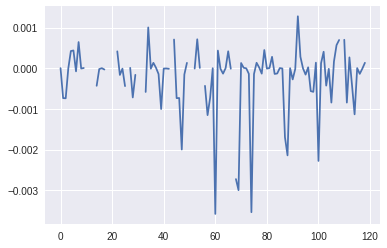

In [10]:
# Plot intraday returns (features) for one security
plt.plot(range(119),train_data.iloc[0,27:146])
plt.show()

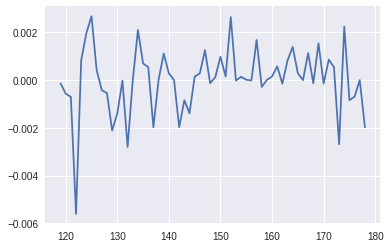

In [11]:
# Plot intraday returns (targets) for one security
plt.plot(range(119,119+60),train_data.iloc[0,146:206])
plt.show()

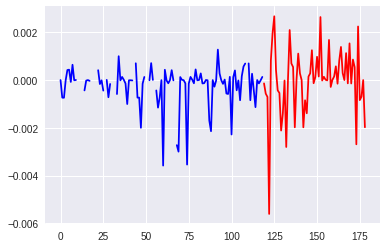

In [12]:
# Combine features and targets
plt.plot(range(119),train_data.iloc[0,27:146], c='blue')
plt.plot(range(119,119+60),train_data.iloc[0,146:206], c='red')
plt.show()

## 2. Feature Engineering

### Replacing NaN Values

Initially, we will replace NaN with an estimate based on interpolation. Our final submission will employ more sophisticated interpolation models

In [0]:
# Replace non-time series Feature_1, Feature_2,...  data with simple averages
# Maybe we could do a linear regression on these?
for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
    train_data[featcol] = train_data[featcol].fillna(train_data[featcol].mean())
  
for featcol in filter(lambda x: x.startswith('Feature_'), test_data.columns):
    test_data[featcol] = test_data[featcol].fillna(test_data[featcol].mean())

# Linearly interpolate 1-D time series data
# Only interpolate columns which look like 'Ret_2', 'Ret_3', ..., 'Ret_180'
# although columns 'Ret_121', 'Ret_122', ..., 'Ret_180' are always filled anyway b/c they are response vars
ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, train_data.columns))
train_data.loc[:, ret_cols] = train_data[ret_cols].interpolate(axis=1, limit_direction='both')

ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, test_data.columns))
test_data.loc[:, ret_cols] = test_data[ret_cols].interpolate(axis=1, limit_direction='both')

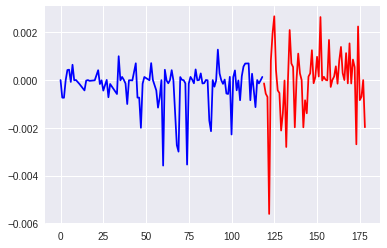

In [14]:
# Regenerate plot from above with interpolated values
plt.plot(range(119),train_data.iloc[0,27:146], c='blue')
plt.plot(range(119,119+60),train_data.iloc[0,146:206], c='red')
plt.show()

In [15]:
# Verify all nans are gone
print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


Data minus header and index number

In [16]:
train_values = train_data.values
print(train_values[:5])
test_values = test_data.values
print(test_values[:5])

[[  3.59024974e+00  -1.17557876e-01   5.58392487e-01 ...,   2.88463640e-02
    1.25150797e+06   1.56438496e+06]
 [  3.59024974e+00  -1.17557876e-01   5.58392487e-01 ...,  -1.02532060e-02
    1.73395035e+06   2.16743794e+06]
 [  3.59024974e+00  -6.96726938e-01   7.39590680e-01 ...,   1.57107390e-02
    1.52919738e+06   1.91149673e+06]
 [  3.59024974e+00  -6.94349689e-01   1.56824808e+00 ...,  -2.19045800e-03
    1.71156942e+06   2.13946178e+06]
 [  6.00000000e+00  -1.73648913e+00   2.76553073e+00 ...,  -2.65516000e-02
    1.26727026e+06   1.58408783e+06]]
[[  1.00000000e+00   1.41278265e+00  -5.62843240e-02   4.07434402e-01
    1.00000000e+01   4.13225939e-01   1.88710000e+04   2.13800000e-01
    1.10000000e+01   4.74756819e+00  -2.29909847e-01   9.70000000e-01
    8.00000000e+00   1.68313397e+00   1.25133271e+01   1.00000000e+00
   -1.45889409e-01   1.62457272e-01  -6.50405957e-01   7.00000000e+00
    6.13651501e-01  -7.09206020e-01  -4.10661666e+00  -5.56802446e-01
   -4.01188838e-01 

In [0]:
train_values = train_values.astype('float64')
test_values = test_values.astype('float64')

### Scaling Data

In [18]:
print(train_values.shape)
print(test_values.shape)

(40000, 210)
(120000, 146)


In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_values)
test_scaled = scaler.fit_transform(test_values)

Here we verify number of elements in list 

In [20]:
n_columns = 0
for x in train_scaled[:1]:
    for y in x:
        n_columns+=1
print(n_columns)

n_columns = 0
for x in test_scaled[:1]:
    for y in x:
        n_columns+=1
print(n_columns)

210
146


**For Train Data**

$+ 25$ feature columns (Feature_1, ..., Feature_25) 

$+ 179$ intraday returns columns (Ret_2, ..., Ret_180)

$ + 6$ other (Ret_MinusTwo, Ret_MinusOne, Ret_PlusOne, Ret_PlusTwo, Weight_IntraDay, Weight_Daily)

$= 210$ total

**For Test Data**

$+ 25$ feature columns (Feature_1, ..., Feature_25) 

$+ 119$ intraday returns columns (Ret_2, ..., Ret_120)

$ + 2$ other (Ret_MinusTwo, Ret_MinusOne)

$= 146$ total

### Splitting Data into Train/Dev/Test Sets

In [21]:
t_col_split = train_data.columns.get_loc('Ret_121')
print(t_col_split)

t_row_split = int(0.9*len(train_data))
print(t_row_split)

# Parse out train and dev sets using scaled data
#train = train_scaled[:t_row_split, :]
#dev = train_scaled[t_row_split:, :]
train = train_data.as_matrix()[:t_row_split, :]
dev = train_data.as_matrix()[t_row_split:, :]

# Scale test data
#test = test_scaled
test = test_data.as_matrix()

shuffle = np.random.permutation(np.arange(train.shape[0]))
train = train[shuffle]

print(train.shape)
print(dev.shape)
print(test.shape)

train_data = train[:, :t_col_split]
train_labels_intra = train[:,t_col_split:t_col_split+60]
train_labels_daily = train[:,t_col_split+60:t_col_split+62]
train_weights_intra = train[:,-2]
train_weights_daily = train[:,-1]

dev_data = dev[:, :t_col_split]
dev_labels_intra = dev[:,t_col_split:t_col_split+60]
dev_labels_daily = dev[:,t_col_split+60:t_col_split+62]
dev_weights_intra = dev[:,-2]
dev_weights_daily = dev[:,-1]

test_data = test

print("Train shape: ", train_data.shape, train_labels_intra.shape, train_labels_daily.shape, train_weights_intra.shape, train_weights_daily.shape)
print("Dev shape: ", dev_data.shape, train_labels_intra.shape, train_labels_daily.shape, dev_weights_intra.shape, dev_weights_daily.shape)
print("Test shape: ", test_data.shape)

146
36000
(36000, 210)
(4000, 210)
(120000, 146)
('Train shape: ', (36000, 146), (36000, 60), (36000, 2), (36000,), (36000,))
('Dev shape: ', (4000, 146), (36000, 60), (36000, 2), (4000,), (4000,))
('Test shape: ', (120000, 146))


## 3. Linear/Ridge/Lasso (Baseline)

### Linear Regression


In [22]:
# Intraday prediction
lm = LinearRegression()
lm.fit(train_data, train_labels_intra, train_weights_intra)
print("(Intraday) Linear model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_intra, lm.predict(dev_data), dev_weights_intra))

# Daily prediction
lm = LinearRegression()
lm.fit(train_data, train_labels_daily, train_weights_daily)
print("(Daily) Linear model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_daily, lm.predict(dev_data), dev_weights_daily))

('(Intraday) Linear model weighted mean abs err: ', 937.14433274470173)
('(Daily) Linear model weighted mean abs err: ', 27410.423472592767)


### Ridge Regression

In [23]:
# Intraday prediction
rm = Ridge(alpha=1, normalize=True)
rm.fit(train_data, train_labels_intra, train_weights_intra)
print("(Intraday) Ridge model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_intra, rm.predict(dev_data), dev_weights_intra))

# Daily prediction
rm = Ridge(alpha=1, normalize=True)
rm.fit(train_data, train_labels_daily, train_weights_daily)
print("(Daily) Ridge model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_daily, rm.predict(dev_data), dev_weights_daily))

('(Intraday) Ridge model weighted mean abs err: ', 937.14428342317228)
('(Daily) Ridge model weighted mean abs err: ', 27410.422848870723)


('Average run time = ', 0.28395027773720877)
('Average dev mse  = ', 1.1334845937636315e-06)


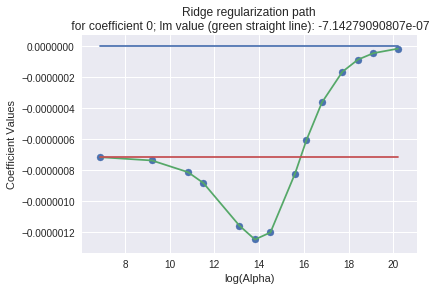

('Average run time = ', 0.2892660413469587)
('Average dev mse  = ', 1.1334845937636315e-06)


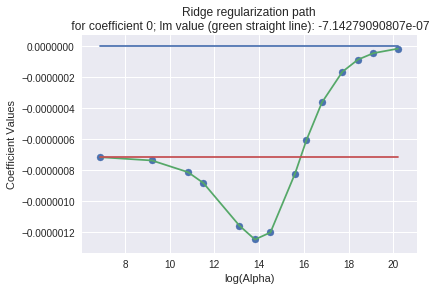

('Average run time = ', 0.28599936621529715)
('Average dev mse  = ', 1.1334845937636315e-06)


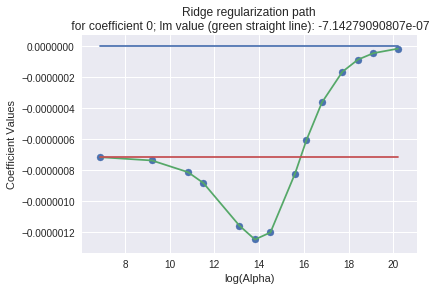

('Average run time = ', 0.28580810342516216)
('Average dev mse  = ', 1.1334845937636315e-06)


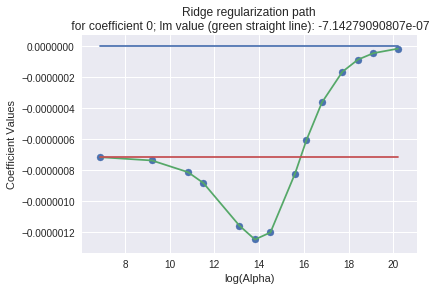

('Average run time = ', 1.1036521366664342)
('Average dev mse  = ', 1.1334845937636315e-06)


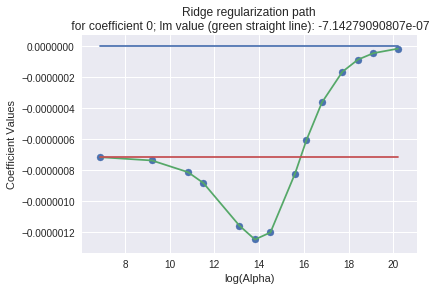

('Average run time = ', 1.109234026500157)
('Average dev mse  = ', 1.1334845937636315e-06)


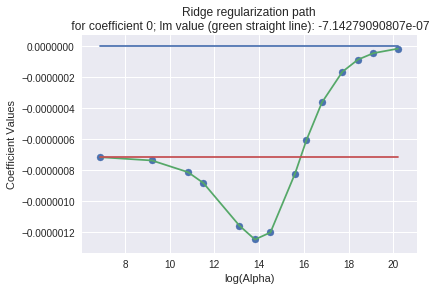

('Average run time = ', 1.1130220549447196)
('Average dev mse  = ', 1.1334845937636315e-06)


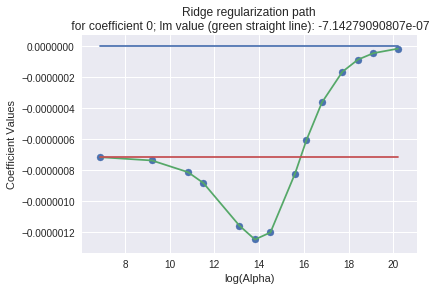

('Average run time = ', 1.1002572774887085)
('Average dev mse  = ', 1.1334845937636315e-06)


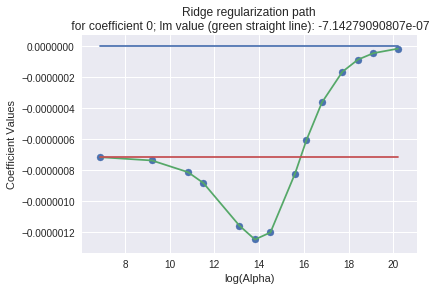

('Average run time = ', 0.2838336229324341)
('Average dev mse  = ', 1.1334845937636315e-06)


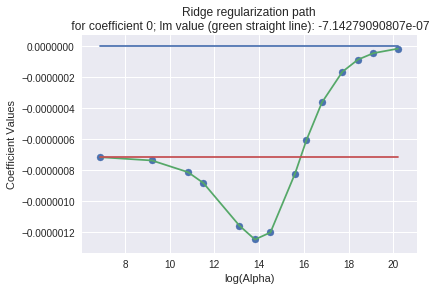

('Average run time = ', 0.28408404758998324)
('Average dev mse  = ', 1.1334845937636315e-06)


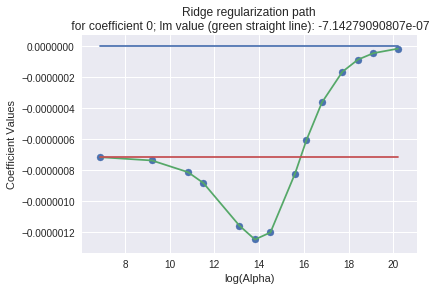

('Average run time = ', 0.28267014026641846)
('Average dev mse  = ', 1.1334845937636315e-06)


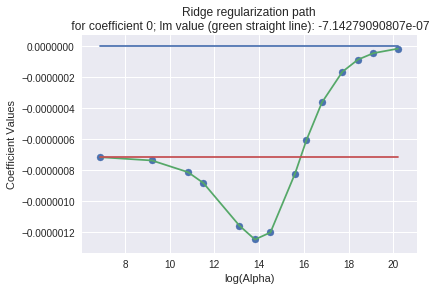

('Average run time = ', 0.28430490834372385)
('Average dev mse  = ', 1.1334845937636315e-06)


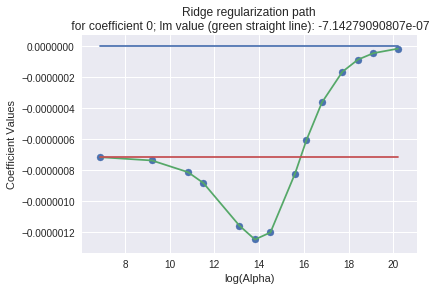

('Average run time = ', 0.2447418144771031)
('Average dev mse  = ', 1.1406764400458664e-06)


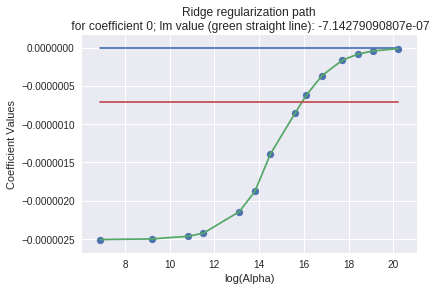

('Average run time = ', 0.249642014503479)
('Average dev mse  = ', 1.1335770603187707e-06)


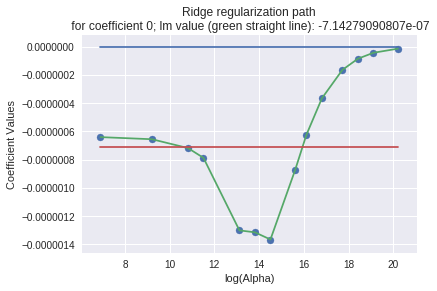

('Average run time = ', 0.26739372525896343)
('Average dev mse  = ', 1.133420577044486e-06)


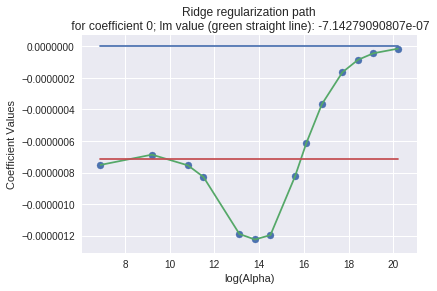

('Average run time = ', 0.2958622489656721)
('Average dev mse  = ', 1.1334933523359183e-06)


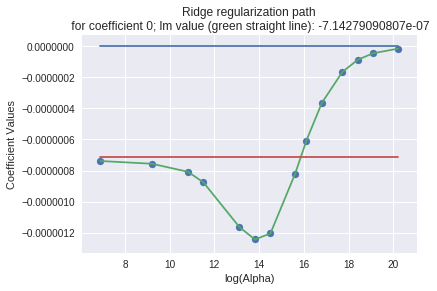

('Average run time = ', 0.2443107877458845)
('Average dev mse  = ', 1.1325094433012352e-06)


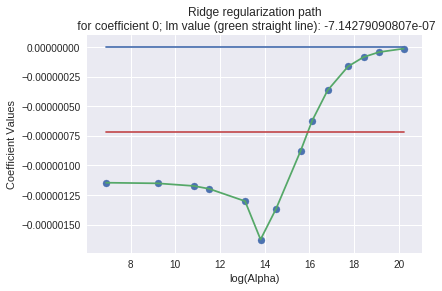

('Average run time = ', 0.2678196430206299)
('Average dev mse  = ', 1.1334343030498909e-06)


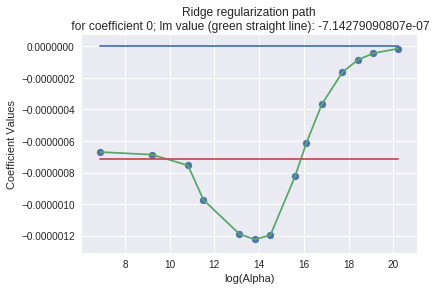

('Average run time = ', 0.29524568149021696)
('Average dev mse  = ', 1.1334921697390512e-06)


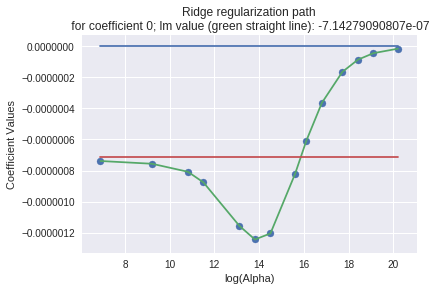

('Average run time = ', 0.31721341609954834)
('Average dev mse  = ', 1.1334837745459835e-06)


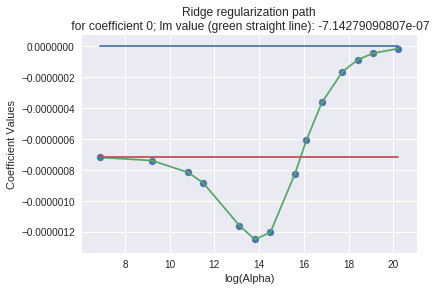

[ -7.18598958e-07  -7.38703816e-07  -8.15198984e-07  -8.84755175e-07
  -1.15979828e-06  -1.24956971e-06  -1.20273124e-06  -8.23378010e-07
  -6.06399939e-07  -3.62860353e-07  -1.64172244e-07  -8.58091038e-08
  -4.39037306e-08  -1.48660634e-08]


In [24]:
import datetime
import time

alpha_vec = [ 1000, 10000, 50000, 100000, 500000, 1000000, 2000000, 6000000, 10000000, 20000000, 50000000, 100000000 , 200000000, 600000000]

solvers = ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]

colors  = ["red", "blue", "green", "brown", "yellow"]

tols = [ 0.1, 0.01, 0.001, 0.0001 ]

coef_idx = 0
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

for solver in solvers:
  lm = LinearRegression()
  lm.fit(train_data, train_labels_intra[:,0], train_weights_intra) # Only fit to first intraday target
  lm_coef = lm.coef_[coef_idx]
  lm_dev_mse = ((lm.predict(dev_data) - dev_labels_intra[:,0]) ** 2).mean()
  
  for tol in tols:
    run_time_arr = []
    rm_dev_mse_arr = []
    
    for aa_idx, aa in enumerate(alpha_vec):
      
      start_time = time.time()
      
      rm = Ridge(alpha=aa, solver=solver, tol=tol, normalize=True)
      rm.fit(train_data, train_labels_intra[:,0], train_weights_intra)  # Only fit to first intraday target
      rm_coef = rm.coef_[coef_idx]

      coef_values[aa_idx] = rm_coef
      lm_coef_line[aa_idx] = lm_coef

      rm_dev_mse = ((rm.predict(dev_data) - dev_labels_intra[:,0]) ** 2).mean()
      
      run_time_arr.append(time.time() - start_time )
      rm_dev_mse_arr.append(rm_dev_mse)
     
    print("Average run time = ", sum(run_time_arr)/len(run_time_arr))
    print("Average dev mse  = ", sum(rm_dev_mse_arr)/len(rm_dev_mse_arr))
      
    #print("SOLVER = ", solver, " TOL = ", tol, "RUN_TIME = ", "Alpha = ", aa, "RM_DEV_MSE = ", rm_dev_mse, "Worse on the test set? ", lm_dev_mse > rm_dev_mse )
    
    
    plt.plot(np.log(alpha_vec), lm_coef_line * 0)
    plt.plot(np.log(alpha_vec), coef_values)
    plt.plot(np.log(alpha_vec), lm_coef_line)
    plt.scatter(np.log(alpha_vec), coef_values)
    plt.title('Ridge regularization path\n for coefficient ' + str(coef_idx) + '; lm value (green straight line): ' + str(lm_coef))
    plt.ylabel('Coefficient Values') 
    plt.xlabel('log(Alpha)') 
    plt.show()

print(coef_values)

### Lasso Regression

In [25]:
models = [Lasso]

for model in models:
  # Intraday prediction
  las = model(normalize=True)
  las.fit(train_data, train_labels_intra)
  print("(Intraday)", model.__name__," model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_intra, las.predict(dev_data), dev_weights_intra))

  # Daily prediction
  las = model(normalize=True)
  las.fit(train_data, train_labels_daily)
  print("(Daily)", model.__name__,"model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_daily, las.predict(dev_data), dev_weights_daily))

('(Intraday)', 'Lasso', ' model weighted mean abs err: ', 904.17480968606719)
('(Daily)', 'Lasso', 'model weighted mean abs err: ', 27414.041130284138)


('MODEL = ', 'Lasso', ' TOL = ', 0.1, 'RUN_TIME = ', 'Alpha = ', 1e-08, 'RM_DEV_MSE = ', 1.1710860635130125e-06, 'Worse on the test set? ', False)


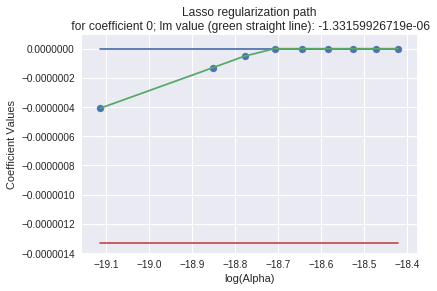

('MODEL = ', 'Lasso', ' TOL = ', 0.01, 'RUN_TIME = ', 'Alpha = ', 1e-08, 'RM_DEV_MSE = ', 1.1710860635130125e-06, 'Worse on the test set? ', False)


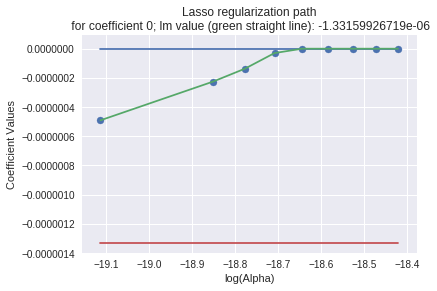

('MODEL = ', 'Lasso', ' TOL = ', 0.001, 'RUN_TIME = ', 'Alpha = ', 1e-08, 'RM_DEV_MSE = ', 1.1710860635130125e-06, 'Worse on the test set? ', False)


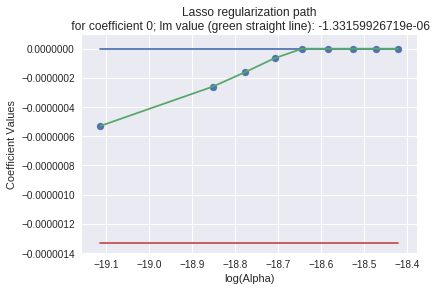

('MODEL = ', 'Lasso', ' TOL = ', 0.0001, 'RUN_TIME = ', 'Alpha = ', 1e-08, 'RM_DEV_MSE = ', 1.1710860635130125e-06, 'Worse on the test set? ', False)


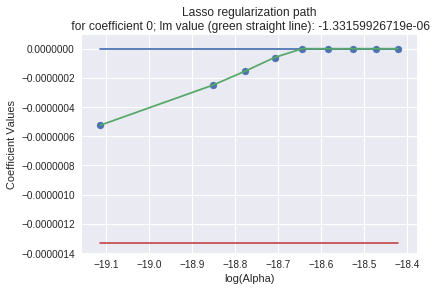

In [26]:
alpha_vec = [ 0.000000005, 0.0000000065, 0.000000007, 0.0000000075, 0.000000008, 0.0000000085, 0.000000009, 0.0000000095, 0.00000001]

colors  = ["red", "blue", "green", "brown", "yellow"]

models = [Lasso]

tols = [ 0.1, 0.01, 0.001, 0.0001 ]

cvs  = [ 2, 4, 6, 8, 10]

coef_idx = 0
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

lm = LinearRegression()
lm.fit(train_data, train_labels_intra[:,0]) # Only fit to first intraday target
lm_coef = lm.coef_[coef_idx]
lm_dev_mse = ((lm.predict(dev_data) - dev_labels_intra[:,0]) ** 2).mean()

for model in models:
  for tol in tols:
    for aa_idx, aa in enumerate(alpha_vec):

        las = model(alpha=aa, tol=tol, normalize=True, max_iter=1000)
        las.fit(train_data, train_labels_intra[:,0]) # Only fit to first intraday target
        las_coef = las.coef_[coef_idx]

        coef_values[aa_idx] = las_coef
        lm_coef_line[aa_idx] = lm_coef

        las_dev_mse = ((las.predict(dev_data) - dev_labels_intra[:,0]) ** 2).mean()
        #print("Alpha is ", aa)
        #print(las_dev_mse)
        #print("Linear regression does worse on the test set: ", lm_dev_mse > las_dev_mse)

    print("MODEL = ", model.__name__, " TOL = ", tol, "RUN_TIME = ", "Alpha = ", aa, "RM_DEV_MSE = ", rm_dev_mse, "Worse on the test set? ", lm_dev_mse > rm_dev_mse )


    plt.plot(np.log(alpha_vec), lm_coef_line * 0)
    plt.plot(np.log(alpha_vec), coef_values)
    plt.plot(np.log(alpha_vec), lm_coef_line)
    plt.scatter(np.log(alpha_vec), coef_values)
    plt.title('Lasso regularization path\n for coefficient ' + str(coef_idx) + 
              '; lm value (green straight line): ' + str(lm_coef))
    plt.ylabel('Coefficient Values') 
    plt.xlabel('log(Alpha)') 
    plt.show()

### Apply to Test Data

In [27]:
# Intraday prediction
las = Lasso(normalize=True)
las.fit(train_data, train_labels_intra)
preds_intra = las.predict(test_data)

# Daily prediction
las = Lasso(normalize=True)
las.fit(train_data, train_labels_daily)
preds_daily = las.predict(test_data)

preds = np.concatenate((preds_intra, preds_daily), axis=1)

print(preds_intra.shape)
print(preds_daily.shape)
print(preds.shape)

(120000, 60)
(120000, 2)
(120000, 62)


### Save Predictions in CSV

In [0]:
with open('submission.csv', 'w') as f:
  f.write('Id,Predicted\n')
  for security in range(60000):
    for pred in range(preds.shape[1]):
        f.write(str(security+1) + '_' + str(pred+1) + ',' + str(preds[security,pred]) + '\n')
        
files.download('submission.csv')

with open('submission2.csv', 'w') as f2:
  for security in range(60000,preds.shape[0]):
    for pred in range(preds.shape[1]):
        f2.write(str(security+1) + '_' + str(pred+1) + ',' + str(preds[security,pred]) + '\n')

files.download('submission2.csv')

## 4. Gradient Boosting

### AdaBoost Regression

In [29]:
ab_intra = MultiOutputRegressor(AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=5, learning_rate=0.1))
ab_daily = MultiOutputRegressor(AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=5, learning_rate=0.1))

# Intraday prediction
ab_intra.fit(train_data, train_labels_intra, train_weights_intra)
intra_preds = ab_intra.predict(dev_data)
print("(Intraday) AdaBoost model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_intra, intra_preds, dev_weights_intra))

# Daily prediction
ab_daily.fit(train_data, train_labels_daily, train_weights_daily)
daily_preds = ab_daily.predict(dev_data)
print("(Daily) AdaBoost model weighted mean abs err: ", weighted_mean_abs_err(dev_labels_daily, daily_preds, dev_weights_daily))

KeyboardInterrupt: ignored

### Apply to Test Data

In [0]:
# Intraday prediction
preds_intra = ab_intra.predict(test_data)

# Daily prediction
preds_daily = ab_daily.predict(test_data)

preds = np.concatenate((preds_intra, preds_daily), axis=1)

print(preds_intra.shape)
print(preds_daily.shape)
print(preds.shape)

(120000, 60)
(120000, 2)
(120000, 62)


### Save Predictions in CSV

In [0]:
with open('submission.csv', 'w') as f:
  f.write('Id,Predicted\n')
  for security in range(60000):
    for pred in range(preds.shape[1]):
        f.write(str(security+1) + '_' + str(pred+1) + ',' + str(preds[security,pred]) + '\n')
        
files.download('submission.csv')

with open('submission2.csv', 'w') as f2:
  for security in range(60000,preds.shape[0]):
    for pred in range(preds.shape[1]):
        f2.write(str(security+1) + '_' + str(pred+1) + ',' + str(preds[security,pred]) + '\n')

files.download('submission2.csv')

## 5. Random Forest

### Import packages

In [30]:
%matplotlib inline

# Import SciKitLearn
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# Other packages
import numpy as np
import pandas as pd
import re
import scipy as sp
import matplotlib.pyplot as plt
from numpy import concatenate
from pandas import DataFrame, Series, read_csv, scatter_matrix
from google.colab import files

# Install packages
!pip install keras

# Weighted Mean Absolute Error Function
def weighted_mean_abs_err(y_true, y_pred, weights):
  return np.mean(np.mean(np.abs(y_true - y_pred), axis=1) * weights)

### Load data

In [0]:
# Load Train Data
train_data1 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train1.csv")
train_data2 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train2.csv")
train_data3 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train3.csv")
train_data4 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/train4.csv")
raw_train_data = pd.concat([train_data1, train_data2, train_data3, train_data4], ignore_index=True)

# Load Test Data
test_data1 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test1.csv")
test_data2 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test2.csv")
test_data3 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test3.csv")
test_data4 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test4.csv")
test_data5 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test5.csv")
test_data6 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test6.csv")
test_data7 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test7.csv")
test_data8 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test8.csv")
test_data9 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test9.csv")
test_data10 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test10.csv")
test_data11 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test11.csv")
test_data12 = read_csv("https://github.com/kr900910/winton-stock-market-challenge/raw/master/test12.csv")
raw_test_data = pd.concat([test_data1, test_data2, test_data3, test_data4, test_data5, test_data6, test_data7, test_data8, test_data9, test_data10, test_data11, test_data12], ignore_index=True)

# Strip off first column
raw_train_data = raw_train_data[raw_train_data.columns[1:]]
raw_test_data = raw_test_data[raw_test_data.columns[1:]]

In [0]:
train_data = raw_train_data.copy()

for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
  train_data[featcol] = train_data[featcol].fillna(0)

ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, train_data.columns))
for col in ret_cols:
  train_data.loc[:, col] = train_data[col].interpolate(method='linear', limit_direction='both')

t_col_split = train_data.columns.get_loc('Ret_121')

t_row_split = int(len(train_data)/3)

train_data = train_data.as_matrix()
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data = train_data[shuffle]

train = train_data[:t_row_split, :]
dev = train_data[t_row_split:, :]

train_data = train[:, :t_col_split]
train_labels_intra = train[:,t_col_split:t_col_split+60]
train_labels_daily = train[:,t_col_split+60:t_col_split+62]
train_weights_intra = train[:,-2]
train_weights_daily = train[:,-1]

dev_data = dev[:, :t_col_split]
dev_labels_intra = dev[:,t_col_split:t_col_split+60]
dev_labels_daily = dev[:,t_col_split+60:t_col_split+62]
dev_weights_intra = dev[:,-2]
dev_weights_daily = dev[:,-1]

### Random forest using different node sizes

In [33]:
min_samples_split = [2, 5, 10, 25, 50, 100, 200]

for s in min_samples_split:

  # Random Forest Regression
  rf = RandomForestRegressor(criterion='mae', min_samples_split=s)

  # Intraday prediction
  rf.fit(train_data, train_labels_intra, train_weights_intra)
  preds_intra = rf.predict(dev_data)
  error_intra = weighted_mean_abs_err(dev_labels_intra, preds_intra, dev_weights_intra)

  # Daily prediction
  rf.fit(train_data, train_labels_daily, train_weights_daily)
  preds_daily = rf.predict(dev_data)
  error_daily = weighted_mean_abs_err(dev_labels_daily, preds_daily, dev_weights_daily)

  # Combined error
  intra_num_preds = dev_labels_intra.shape[0] * dev_labels_intra.shape[1]
  daily_num_preds = dev_labels_daily.shape[0] * dev_labels_daily.shape[1]
  error_combined = ((error_intra * intra_num_preds) + (error_daily * daily_num_preds)) / (intra_num_preds + daily_num_preds)

  print("Minimum node size:", s)
  print("Intraday error:", error_intra)
  print("Daily error:", error_daily)
  print("Combined error:", error_combined)
  print('')

('Minimum node size:', 2)
('Intraday error:', 902.67892258076529)
('Daily error:', 27750.878057553273)
('Combined error:', 1768.7498624185882)

('Minimum node size:', 5)
('Intraday error:', 902.67855184455561)
('Daily error:', 27750.976270137755)
('Combined error:', 1768.7526717894973)

('Minimum node size:', 10)
('Intraday error:', 902.67771063181203)
('Daily error:', 27750.657352709986)
('Combined error:', 1768.7415700536887)

('Minimum node size:', 25)
('Intraday error:', 902.67856776787221)
('Daily error:', 27750.993523903573)
('Combined error:', 1768.7532437722498)

('Minimum node size:', 50)
('Intraday error:', 902.67922675880504)
('Daily error:', 27750.687281872521)
('Combined error:', 1768.7440027302152)

('Minimum node size:', 100)
('Intraday error:', 902.67872150327128)
('Daily error:', 27750.92676757474)
('Combined error:', 1768.7512391184798)

('Minimum node size:', 200)
('Intraday error:', 902.67843279743283)
('Daily error:', 27750.984766559413)
('Combined error:', 1768.75

### Random forest using scaled features

In [0]:
train_data = raw_train_data.copy()

for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
  train_data[featcol] = train_data[featcol].fillna(0)

ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, train_data.columns))
for col in ret_cols:
  train_data.loc[:, col] = train_data[col].interpolate(method='linear', limit_direction='both')

t_col_split = train_data.columns.get_loc('Ret_121')

t_row_split = int(len(train_data)/3)

train_data = train_data.as_matrix()
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data = train_data[shuffle]

train = train_data[:t_row_split, :]
dev = train_data[t_row_split:, :]

scaler = MinMaxScaler()

train_data = train[:, :t_col_split]
scaler.fit(train_data)
train_data = scaler.transform(train_data)
train_labels_intra = train[:,t_col_split:t_col_split+60]
train_labels_daily = train[:,t_col_split+60:t_col_split+62]
train_weights_intra = train[:,-2]
train_weights_daily = train[:,-1]

dev_data = dev[:, :t_col_split]
scaler.fit(dev_data)
dev_data = scaler.transform(dev_data)
dev_labels_intra = dev[:,t_col_split:t_col_split+60]
dev_labels_daily = dev[:,t_col_split+60:t_col_split+62]
dev_weights_intra = dev[:,-2]
dev_weights_daily = dev[:,-1]

In [35]:
min_samples_split = [2, 5, 10, 25, 50, 100, 200]

for s in min_samples_split:

  # Random Forest Regression
  rf = RandomForestRegressor(criterion='mae', min_samples_split=s)

  # Intraday prediction
  rf.fit(train_data, train_labels_intra, train_weights_intra)
  preds_intra = rf.predict(dev_data)
  error_intra = weighted_mean_abs_err(dev_labels_intra, preds_intra, dev_weights_intra)

  # Daily prediction
  rf.fit(train_data, train_labels_daily, train_weights_daily)
  preds_daily = rf.predict(dev_data)
  error_daily = weighted_mean_abs_err(dev_labels_daily, preds_daily, dev_weights_daily)

  # Combined error
  intra_num_preds = dev_labels_intra.shape[0] * dev_labels_intra.shape[1]
  daily_num_preds = dev_labels_daily.shape[0] * dev_labels_daily.shape[1]
  error_combined = ((error_intra * intra_num_preds) + (error_daily * daily_num_preds)) / (intra_num_preds + daily_num_preds)

  print("Minimum node size:", s)
  print("Intraday error:", error_intra)
  print("Daily error:", error_daily)
  print("Combined error:", error_combined)
  print('')

('Minimum node size:', 2)
('Intraday error:', 906.74982210049779)
('Daily error:', 27957.623415125716)
('Combined error:', 1779.3586476819567)

('Minimum node size:', 5)
('Intraday error:', 906.7493454577691)
('Daily error:', 27957.27883719953)
('Combined error:', 1779.347070997826)

('Minimum node size:', 10)
('Intraday error:', 906.74819256253238)
('Daily error:', 27958.291484660156)
('Combined error:', 1779.3786213398751)

('Minimum node size:', 25)
('Intraday error:', 906.74923130261652)
('Daily error:', 27958.240412916708)
('Combined error:', 1779.3779790966196)

('Minimum node size:', 50)
('Intraday error:', 906.74974337225729)
('Daily error:', 27956.715146641749)
('Combined error:', 1779.3292725099827)

('Minimum node size:', 100)
('Intraday error:', 906.74890673406867)
('Daily error:', 27957.167343111039)
('Combined error:', 1779.3430498430032)

('Minimum node size:', 200)
('Intraday error:', 906.74919808024606)
('Daily error:', 27957.364399379363)
('Combined error:', 1779.3496

### Random forest using different depths

In [36]:
for depth in range(1,11):

  # Random Forest Regression
  rf = RandomForestRegressor(criterion='mae', max_depth=depth)

  # Intraday prediction
  rf.fit(train_data, train_labels_intra, train_weights_intra)
  preds_intra = rf.predict(dev_data)
  error_intra = weighted_mean_abs_err(dev_labels_intra, preds_intra, dev_weights_intra)

  # Daily prediction
  rf.fit(train_data, train_labels_daily, train_weights_daily)
  preds_daily = rf.predict(dev_data)
  error_daily = weighted_mean_abs_err(dev_labels_daily, preds_daily, dev_weights_daily)

  # Combined error
  intra_num_preds = dev_labels_intra.shape[0] * dev_labels_intra.shape[1]
  daily_num_preds = dev_labels_daily.shape[0] * dev_labels_daily.shape[1]
  error_combined = ((error_intra * intra_num_preds) + (error_daily * daily_num_preds)) / (intra_num_preds + daily_num_preds)
  
  print("Maximum tree depth:", depth)
  print("Intraday error:", error_intra)
  print("Daily error:", error_daily)
  print("Combined error:", error_combined)
  print('')

('Maximum tree depth:', 1)
('Intraday error:', 906.75021702492916)
('Daily error:', 27958.164611109187)
('Combined error:', 1779.376487801841)

('Maximum tree depth:', 2)
('Intraday error:', 906.74912096198591)
('Daily error:', 27957.808847440232)
('Combined error:', 1779.3639508483809)

('Maximum tree depth:', 3)
('Intraday error:', 906.74891766595158)
('Daily error:', 27957.000242591221)
('Combined error:', 1779.3376700828956)

('Maximum tree depth:', 4)
('Intraday error:', 906.75022846522927)
('Daily error:', 27957.595674214761)
('Combined error:', 1779.3581460700527)

('Maximum tree depth:', 5)
('Intraday error:', 906.74985353110526)
('Daily error:', 27957.407295472844)
('Combined error:', 1779.3517064969678)

('Maximum tree depth:', 6)
('Intraday error:', 906.75004019126141)
('Daily error:', 27958.311373122502)
('Combined error:', 1779.3810509309787)

('Maximum tree depth:', 7)
('Intraday error:', 906.75018060567947)
('Daily error:', 27958.720116834775)
('Combined error:', 1779.39

### Random forest using different numbers of estimators

In [0]:
n_estimators = [5, 10, 20, 50, 100, 200, 500, 1000]

for n in n_estimators:

  # Random Forest Regression
  rf = RandomForestRegressor(criterion='mae', n_estimators=n, max_depth=depth, min_samples_split=5)

  # Intraday prediction
  rf.fit(train_data, train_labels_intra, train_weights_intra)
  preds_intra = rf.predict(dev_data)
  error_intra = weighted_mean_abs_err(dev_labels_intra, preds_intra, dev_weights_intra)

  # Daily prediction
  rf.fit(train_data, train_labels_daily, train_weights_daily)
  preds_daily = rf.predict(dev_data)
  error_daily = weighted_mean_abs_err(dev_labels_daily, preds_daily, dev_weights_daily)

  # Combined error
  intra_num_preds = dev_labels_intra.shape[0] * dev_labels_intra.shape[1]
  daily_num_preds = dev_labels_daily.shape[0] * dev_labels_daily.shape[1]
  error_combined = ((error_intra * intra_num_preds) + (error_daily * daily_num_preds)) / (intra_num_preds + daily_num_preds)
  
  print(n)
  print(error_combined)
  print('')

5
1779.42341054

10
1779.44786423

20
1779.33773754

50
1779.36551154

100
1779.36352665



### Random forest using different interpolation methods

In [0]:
interp_methods = ['linear', 'quadratic', 'cubic', 'akima']

for interp_method in interp_methods:
  
  train_data = raw_train_data.copy()

  for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
    train_data[featcol] = train_data[featcol].fillna(0)

  ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, train_data.columns))
  for col in ret_cols:
    train_data.loc[:, col] = train_data[col].interpolate(method=interp_method, limit_direction='both')
    train_data.loc[:, col] = train_data[col].interpolate(method='linear', limit_direction='both')

  t_col_split = train_data.columns.get_loc('Ret_121')

  t_row_split = int(0.8*len(train_data))

  train_data = train_data.as_matrix()

  np.random.seed = 1
  shuffle = np.random.permutation(np.arange(train_data.shape[0]))
  train_data = train_data[shuffle]

  train = train_data[:t_row_split, :]
  dev = train_data[t_row_split:, :]

  train_data = train[:, :t_col_split]
  train_labels_intra = train[:,t_col_split:t_col_split+60]
  train_labels_daily = train[:,t_col_split+60:t_col_split+62]
  train_weights_intra = train[:,-2]
  train_weights_daily = train[:,-1]

  dev_data = dev[:, :t_col_split]
  dev_labels_intra = dev[:,t_col_split:t_col_split+60]
  dev_labels_daily = dev[:,t_col_split+60:t_col_split+62]
  dev_weights_intra = dev[:,-2]
  dev_weights_daily = dev[:,-1]

  # Random Forest Regression
  rf = RandomForestRegressor(criterion='mae', min_samples_split=50)

  # Intraday prediction
  rf.fit(train_data, train_labels_intra, train_weights_intra)
  preds_intra = rf.predict(dev_data)
  error_intra = weighted_mean_abs_err(dev_labels_intra, preds_intra, dev_weights_intra)

  # Daily prediction
  rf.fit(train_data, train_labels_daily, train_weights_daily)
  preds_daily = rf.predict(dev_data)
  error_daily = weighted_mean_abs_err(dev_labels_daily, preds_daily, dev_weights_daily)

  # Combined error
  intra_num_preds = dev_labels_intra.shape[0] * dev_labels_intra.shape[1]
  daily_num_preds = dev_labels_daily.shape[0] * dev_labels_daily.shape[1]
  error_combined = ((error_intra * intra_num_preds) + (error_daily * daily_num_preds)) / (intra_num_preds + daily_num_preds)

  print(interp_method)
  print(error_combined)
  print('')

### Final random forest

In [0]:
train_data = raw_train_data.copy()

for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
    train_data[featcol] = train_data[featcol].fillna(train_data[featcol].mean())
  
# for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
#   train_data[featcol] = train_data[featcol].fillna(0)

ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, train_data.columns))
for col in ret_cols:
  train_data.loc[:, col] = train_data[col].interpolate(method='cubic', limit_direction='both')
  train_data.loc[:, col] = train_data[col].interpolate(method='linear', limit_direction='both')

t_col_split = train_data.columns.get_loc('Ret_121')

t_row_split = int(0.9*len(train_data))

train_data = train_data.as_matrix()
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data = train_data[shuffle]

train = train_data[:t_row_split, :]
dev = train_data[t_row_split:, :]

train_data = train[:, :t_col_split]
train_labels_intra = train[:,t_col_split:t_col_split+60]
train_labels_daily = train[:,t_col_split+60:t_col_split+62]
train_weights_intra = train[:,-2]
train_weights_daily = train[:,-1]

dev_data = dev[:, :t_col_split]
dev_labels_intra = dev[:,t_col_split:t_col_split+60]
dev_labels_daily = dev[:,t_col_split+60:t_col_split+62]
dev_weights_intra = dev[:,-2]
dev_weights_daily = dev[:,-1]

# Random Forest Regression
rf = RandomForestRegressor(criterion='mae', max_depth=4)

# Intraday prediction
rf.fit(train_data, train_labels_intra, train_weights_intra)
preds_intra = rf.predict(dev_data)
error_intra = weighted_mean_abs_err(dev_labels_intra, preds_intra, dev_weights_intra)

# Daily prediction
rf.fit(train_data, train_labels_daily, train_weights_daily)
preds_daily = rf.predict(dev_data)
error_daily = weighted_mean_abs_err(dev_labels_daily, preds_daily, dev_weights_daily)

# Combined error
intra_num_preds = dev_labels_intra.shape[0] * dev_labels_intra.shape[1]
daily_num_preds = dev_labels_daily.shape[0] * dev_labels_daily.shape[1]
error_combined = ((error_intra * intra_num_preds) + (error_daily * daily_num_preds)) / (intra_num_preds + daily_num_preds)

print(error_intra)
print(error_daily)
print(error_combined)

899.719427462
27826.5830072
1768.32793003


### Apply to Test Data

In [0]:
train_data = raw_train_data.copy()

for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
  train_data[featcol] = train_data[featcol].fillna(0)

ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, train_data.columns))
for col in ret_cols:
  train_data.loc[:, col] = train_data[col].interpolate(method='cubic', limit_direction='both')
  train_data.loc[:, col] = train_data[col].interpolate(method='linear', limit_direction='both')

t_col_split = train_data.columns.get_loc('Ret_121')

train = train_data.as_matrix()

train_data = train[:, :t_col_split]
train_labels_intra = train[:,t_col_split:t_col_split+60]
train_labels_daily = train[:,t_col_split+60:t_col_split+62]
train_weights_intra = train[:,-2]
train_weights_daily = train[:,-1]

test_data = raw_test_data.copy()

for featcol in filter(lambda x: x.startswith('Feature_'), test_data.columns):
  test_data[featcol] = test_data[featcol].fillna(0)

ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, test_data.columns))
for col in ret_cols:
  test_data.loc[:, col] = test_data[col].interpolate(method='cubic', limit_direction='both')
  test_data.loc[:, col] = test_data[col].interpolate(method='linear', limit_direction='both')

In [0]:
# Intraday prediction
rf = RandomForestRegressor(criterion='mae', max_depth=4)
rf.fit(train_data, train_labels_intra, train_weights_intra)
preds_intra = rf.predict(test_data)

# Daily prediction
rf = RandomForestRegressor(criterion='mae', max_depth=4)
rf.fit(train_data, train_labels_daily, train_weights_daily)
preds_daily = rf.predict(test_data)

preds = np.concatenate((preds_intra, preds_daily), axis=1)

print(preds_intra.shape)
print(preds_daily.shape)
print(preds.shape)

(120000, 60)
(120000, 2)
(120000, 62)


### Save Predictions in CSV

In [0]:
with open('submission.csv', 'w') as f:
  f.write('Id,Predicted\n')
  for security in range(60000):
    for pred in range(preds.shape[1]):
        f.write(str(security+1) + '_' + str(pred+1) + ',' + str(preds[security,pred]) + '\n')
        
files.download('submission.csv')

with open('submission2.csv', 'w') as f2:
  for security in range(60000,preds.shape[0]):
    for pred in range(preds.shape[1]):
        f2.write(str(security+1) + '_' + str(pred+1) + ',' + str(preds[security,pred]) + '\n')

files.download('submission2.csv')

* Minimum node size of 5
* max_features = p/3 (round down)
* number of trees

## 6. LSTM

### Fitting LSTM Model

Here we train model against t121 to Ret_Plus_Two 

Using example from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Here we use Keras -- need to confirm that Professor is ok with us using this library

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, TimeDistributed

Using TensorFlow backend.


In [0]:
train_data.shape

(36000, 146)

In [0]:
# Try sending all features to the model in a single timestep.
train_X = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
train_Y = np.reshape(train_labels[:,0], (train_labels.shape[0], 1))
dev_X = np.reshape(dev_data, (dev_data.shape[0], 1, dev_data.shape[1]))
dev_Y = np.reshape(dev_labels[:,0], (dev_labels.shape[0], 1))
print(train_X.shape, train_Y.shape, dev_X.shape, dev_Y.shape)

((36000, 1, 146), (36000, 1), (4000, 1, 146), (4000, 1))


In [0]:
num_epochs = n_columns - t_col_split - 2
#num_hidden = 20

# we use a basic network design 
model = Sequential()

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Here we simply fit network
history = model.fit(train_X, train_Y, epochs=num_epochs, batch_size=144, validation_data=(dev_X, dev_Y), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

Train on 36000 samples, validate on 4000 samples


KeyError: ignored

### Evaluating LSTM Model

In [0]:
# make a prediction
yhat = model.predict(dev_X)
dev_X = dev_X.reshape((dev_X.shape[0], dev_X.shape[2]))

print("dev_X shape: ",dev_X.shape)
print("yhat shape: ", yhat.shape)

#invert scaling for forecast
inv_yhat = concatenate((yhat, dev_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
dev_labels = dev_labels.reshape((len(dev_labels), 1))
inv_y = concatenate((dev_labels, dev_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

('dev_X shape: ', (4000, 147))
('yhat shape: ', (4000, 1))


ValueError: ignored

In [0]:
print((concatenate((yhat, dev_X[:, 1:]), axis=1).shape))

(4000, 147)


### Predict as time-series

In [0]:
# First 25 columns are Feature_1, ..., Feature_25
# These are NOT time series
# Next two columns are Ret_MinusTwo and Ret_MinusOne
# Although these can be considered as time series,
# they are much lower sample rate than the intraday data.
# So we will treat them like the Feature_N data.
train_static_feats = train_data[:,:27]
# Columns Ret_2, ..., Ret_120 are proper time series.
train_ts_feats = train_data[:,27:]
print("train_static_feats.shape: ", train_static_feats.shape)
print("train_ts_feats.shape: ", train_ts_feats.shape)

('train_static_feats.shape: ', (36000, 27))
('train_ts_feats.shape: ', (36000, 119))


In [0]:
# For now, just stack the static features on top of the time-series features
# at each timestep. The network will have to figure out what the non-time-series
# features mean. We will help it do this by adding a Dense layer before the LSTM
# input.

n_static = train_static_feats.shape[1]
n_ts = train_ts_feats.shape[1]
static_part = np.reshape(np.repeat(train_static_feats, n_ts, axis=0),
                         (-1, n_ts, n_static))
dynamic_part = np.reshape(train_ts_feats,
                           (-1, n_ts, 1))
train_X_unrolled = np.concatenate([static_part, dynamic_part], axis=2)
print('%d static features, %d dynamic (time-series) features' % (n_static, n_ts))
print('We will unroll each of the %d available training examples into '
      '%d timesteps, each with %d features (%d static + 1 dynamic).' % 
      (train_data.shape[0], n_ts, n_static + 1, n_static))
print('static_part.shape: %s' % str(static_part.shape))
print('dynamic_part.shape: %s' % str(dynamic_part.shape))
print('train_X_unrolled.shape: %s' % str(train_X_unrolled.shape))

# Unroll the dev set as well
dev_X_unrolled = np.concatenate([
    np.reshape(np.repeat(dev_data[:,:27], 119, axis=0), (-1, 119, 27)),
    np.reshape(dev_data[:,27:], (-1, 119, 1))
], axis=2)
print('dev_X_unrolled.shape: %s' % str(dev_X_unrolled.shape))

27 static features, 119 dynamic (time-series) features
We will unroll each of the 36000 available training examples into 119 timesteps, each with 28 features (27 static + 1 dynamic).
static_part.shape: (36000, 119, 27)
dynamic_part.shape: (36000, 119, 1)
train_X_unrolled.shape: (36000, 119, 28)
dev_X_unrolled.shape: (4000, 119, 28)


In [0]:
train_X_unrolled[:,0,:].shape

(36000, 28)

In [0]:

# Take diff of observations within each training example
train_X_unrolled = np.concatenate(
    [train_X_unrolled[:,0,:].reshape(train_X_unrolled.shape[0], 1, -1),
        np.diff(train_X_unrolled, axis=1)],
    axis=1)
dev_X_unrolled = np.concatenate(
    [dev_X_unrolled[:,0,:].reshape(dev_X_unrolled.shape[0], 1, -1),
        np.diff(dev_X_unrolled, axis=1)],
    axis=1)

Train on 36000 samples, validate on 4000 samples
Epoch 1/60
 - 67s - loss: 0.0185 - val_loss: 0.0087
Epoch 2/60
 - 67s - loss: 0.0087 - val_loss: 0.0087
Epoch 3/60
 - 68s - loss: 0.0087 - val_loss: 0.0086
Epoch 4/60
 - 67s - loss: 0.0087 - val_loss: 0.0094
Epoch 5/60
 - 67s - loss: 0.0087 - val_loss: 0.0092
Epoch 6/60
 - 67s - loss: 0.0086 - val_loss: 0.0086
Epoch 7/60
 - 68s - loss: 0.0086 - val_loss: 0.0086
Epoch 8/60
 - 67s - loss: 0.0086 - val_loss: 0.0087
Epoch 9/60
 - 67s - loss: 0.0086 - val_loss: 0.0088
Epoch 10/60
 - 67s - loss: 0.0086 - val_loss: 0.0092
Epoch 11/60
 - 67s - loss: 0.0085 - val_loss: 0.0091
Epoch 12/60
 - 67s - loss: 0.0085 - val_loss: 0.0087
Epoch 13/60
 - 68s - loss: 0.0085 - val_loss: 0.0086
Epoch 14/60
 - 68s - loss: 0.0085 - val_loss: 0.0086
Epoch 15/60
 - 67s - loss: 0.0085 - val_loss: 0.0085
Epoch 16/60
 - 68s - loss: 0.0085 - val_loss: 0.0086
Epoch 17/60
 - 68s - loss: 0.0085 - val_loss: 0.0085
Epoch 18/60
 - 68s - loss: 0.0084 - val_loss: 0.0085
Epoch 

 - 68s - loss: 0.0084 - val_loss: 0.0085
Epoch 44/60
 - 68s - loss: 0.0084 - val_loss: 0.0087
Epoch 45/60
 - 68s - loss: 0.0084 - val_loss: 0.0085
Epoch 46/60
 - 68s - loss: 0.0084 - val_loss: 0.0088
Epoch 47/60
 - 68s - loss: 0.0084 - val_loss: 0.0086
Epoch 48/60
 - 68s - loss: 0.0084 - val_loss: 0.0085
Epoch 49/60
 - 68s - loss: 0.0084 - val_loss: 0.0093
Epoch 50/60
 - 68s - loss: 0.0084 - val_loss: 0.0084
Epoch 51/60
 - 68s - loss: 0.0084 - val_loss: 0.0085
Epoch 52/60
 - 68s - loss: 0.0083 - val_loss: 0.0084
Epoch 53/60
 - 68s - loss: 0.0084 - val_loss: 0.0087
Epoch 54/60
 - 68s - loss: 0.0084 - val_loss: 0.0085
Epoch 55/60
 - 68s - loss: 0.0084 - val_loss: 0.0088
Epoch 56/60
 - 68s - loss: 0.0084 - val_loss: 0.0087
Epoch 57/60
 - 68s - loss: 0.0084 - val_loss: 0.0086
Epoch 58/60
 - 67s - loss: 0.0084 - val_loss: 0.0084
Epoch 59/60
 - 67s - loss: 0.0084 - val_loss: 0.0087
Epoch 60/60
 - 68s - loss: 0.0084 - val_loss: 0.0085


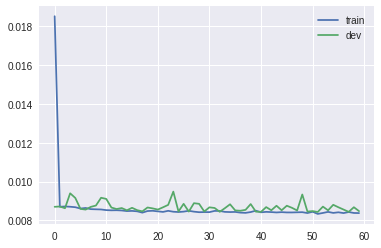

In [0]:
## Now try to use the unrolled features.
num_epochs = 60 # Colaboratory takes about 66s/epoch
num_hidden = 30

# we use a basic network design 
model_unrolled = Sequential()
model_unrolled.add(TimeDistributed(Dense(num_hidden), 
                                   input_shape=(train_X_unrolled.shape[1],
                                                train_X_unrolled.shape[2])))
model_unrolled.add(Activation('relu'))
model_unrolled.add(LSTM(50,
                        input_shape=(train_X_unrolled.shape[1],
                                     num_hidden)))
model_unrolled.add(Dense(1))
model_unrolled.compile(loss='mae', optimizer='adam')

# Here we simply fit network
history_unrolled = model_unrolled.fit(train_X_unrolled, train_Y,
                             epochs=num_epochs,
                             batch_size=144,
                             validation_data=(dev_X_unrolled, dev_Y),
                             verbose=2,
                             shuffle=False)

# plot history
plt.plot(history_unrolled.history['loss'], label='train')
plt.plot(history_unrolled.history['val_loss'], label='dev')
plt.legend()
plt.show()

### MLPRegressor

##### Reusing Seung's Random Forest code 

In [1]:
train_data = raw_train_data.copy()

for featcol in filter(lambda x: x.startswith('Feature_'), train_data.columns):
  train_data[featcol] = train_data[featcol].fillna(0)

ret_cols = list(filter(lambda x: re.match(r'Ret_[0-9]+', str(x)) != None, train_data.columns))
for col in ret_cols:
  train_data.loc[:, col] = train_data[col].interpolate(method='linear', limit_direction='both')

t_col_split = train_data.columns.get_loc('Ret_121')

t_row_split = int(len(train_data)/3)

train_data = train_data.as_matrix()
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
train_data = train_data[shuffle]

train = train_data[:t_row_split, :]
dev = train_data[t_row_split:, :]

scaler = MinMaxScaler()

train_data = train[:, :t_col_split]
scaler.fit(train_data)
train_data = scaler.transform(train_data)
train_labels_intra = train[:,t_col_split:t_col_split+60]
train_labels_daily = train[:,t_col_split+60:t_col_split+62]
train_weights_intra = train[:,-2]
train_weights_daily = train[:,-1]

dev_data = dev[:, :t_col_split]
scaler.fit(dev_data)
dev_data = scaler.transform(dev_data)
dev_labels_intra = dev[:,t_col_split:t_col_split+60]
dev_labels_daily = dev[:,t_col_split+60:t_col_split+62]
dev_weights_intra = dev[:,-2]
dev_weights_daily = dev[:,-1]

NameError: ignored